![PUBG_Logo](assets/PUBG_logo.png)

## Objective
* Employ Prinicpal Components Analyis using selected features on dataset.
* Employ Density-based spatial clustering of applications with noise (DBSCAN) algorithm on dataset
* Discuss pertinent results.

## Background Information
* Playerunknown's Battleground (PUBG) is a video game, which set the standard for preceding games in the Battle Royale Genre. The main goal is to SURVIVE at all costs.

## Process:
* Exploratory Data Analysis conducted utilizing various python packages (Numpy, Matplotlib, Pandas, and Plotly).
* Principal Components Analysis (Sci-Kit Learn)
* DBSCAN (Sci-Kit Learn)


## Table of Contents:
* Part I: Exploratory Data Analysis
    * EDA
* Part II: PCA / DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

# PART I - Exploratory Data Analysis

### Data Preprocessing / Feature Engineering

Let us begin by reading in the CSV file containing the data, and examining the data contents such as the number of features and rows. It seems there are 152 column entries (features) and 87898 row entries (number of samples).

In [2]:
#--------- Pandas Dataframe
## Read in CSV
orig = pd.read_csv('data/PUBG_Player_Statistics.csv')

Now, let us remove and combine features, which do not pertain to our goal of clustering solo player behavior. 

Remove:
* player_name
* tracker_id
* duo
* squad

Add:
* Total Distance

This can be achieved by removing all columns after the 52nd. Also, create a new feature that combines the walking and riding distance.

Also, we will reduce the variance in the data by removing players with less than the mean number of rounds in our data.

In [3]:
#---------Preprocessing
## Create a copy of the dataframe
df = orig.copy()
cols = np.arange(52, 152, 1)

# Drop entries if they have null values
df.dropna(inplace = True)

## Drop columns after the 52nd index
df.drop(df.columns[cols], axis = 1, inplace = True)

## Drop player_name and tracker id
df.drop(df.columns[[0, 1]], axis = 1, inplace = True)

## Drop Knockout and Revives
df.drop(df.columns[[49]], axis = 1, inplace = True)
df.drop(columns = ['solo_Revives'], inplace = True)

## Drop the string solo from all strings
df.rename(columns = lambda x: x.lstrip('solo_').rstrip(''), inplace = True)

## Combine a few columns 
df['TotalDistance'] = df['WalkDistance'] + df['RideDistance']
df['AvgTotalDistance'] = df['AvgWalkDistance'] + df['AvgRideDistance']

# Remove Outliers
df = df.drop(df[df['RoundsPlayed'] < df['RoundsPlayed'].mean()].index)

Split the data into three sets: train, dev, and test set.

In [4]:
# Create train and test set using Sci-Kit Learn
train, test = train_test_split(df, test_size=0.3, random_state = 10)
dev, test = train_test_split(test, test_size = 0.2, random_state = 10)
data = train

print("The number of training samples is", len(train))
print("The number of development samples is", len(dev))
print("The number of testing samples is", len(test))

The number of training samples is 20771
The number of development samples is 7121
The number of testing samples is 1781


It is important we go through the final output to make sure that are data preprocessing is complete. And it looks great!

In [5]:
with pd.option_context('display.max_columns', 52):
    print(data.describe(include = 'all'))

       KillDeathRatio      WinRatio  TimeSurvived  RoundsPlayed          Wins  \
count    20771.000000  20771.000000  2.077100e+04  20771.000000  20771.000000   
mean         1.289158      2.204012  1.484172e+05    174.985894      3.554475   
std          0.602602      2.510500  9.339460e+04    113.147056      4.939222   
min          0.100000      0.000000  3.813548e+04     80.000000      0.000000   
25%          0.900000      0.680000  9.091498e+04    104.000000      1.000000   
50%          1.160000      1.460000  1.195404e+05    139.000000      2.000000   
75%          1.520000      2.910000  1.733681e+05    205.000000      4.000000   
max         17.410000     40.210000  1.219536e+06   1552.000000    102.000000   

       WinTop10Ratio        Top10s    Top10Ratio        Losses        Rating  \
count   20771.000000  20771.000000  20771.000000  20771.000000  20771.000000   
mean        0.138708     23.884743     14.369067    171.431419   2059.159131   
std         0.137145     19.21

The only factors above which have a positive correlation to average survival time are Average Total Distance, Win Ratio, and Top 10 Ratio.

# PART 2 - Clustering

Procedure: 
* 3D

Feature scaling is utilized to make sure all features are normalized and have similar orders of magnitude. This is important because our clustering algorithms look into calculating the distance between points. In our case, we employed a zero-mean and unit-variance scaling.

In [8]:
# Scale the data (Normalize)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train)
X_dev_std = scaler.transform(dev)
X_test_std = scaler.transform(test)

### Principal Components Analysis

The Principal Component Analysis is a dimensional reduction technique that preserves the essence of the original data. Having multi-dimensional data (many features), it is very important in identifying which features are important. PCA finds a new set of dimensions (or a set of basis of views) such that all the dimensions are orthogonal (and hence linearly independent) and ranked according to the variance of data along with them.


#### Algorithm 
1. Calculate the covariance matrix X of data points.
2. Calculate eigenvectors and corresponding eigen values.
3. Sort the eigenvectors according to their eigen values in decreasing order.
4. Choose first k eigen vectors and that will be the new k dimensions.
5. Transform the original n dimensional data points into k dimensions.


#### Parameters

PCA has one parameter:
* Number of components



#### Optimal Number of Components

Now, we'll want to identify the optimal number of principal components. We'll plot the cumulative distribution of variance across several principal components, and identify the number of components that describe 85% of the variance in the data.

Our data suggests 0 - 11 components describe the data, thus a total of 12 components will be used.

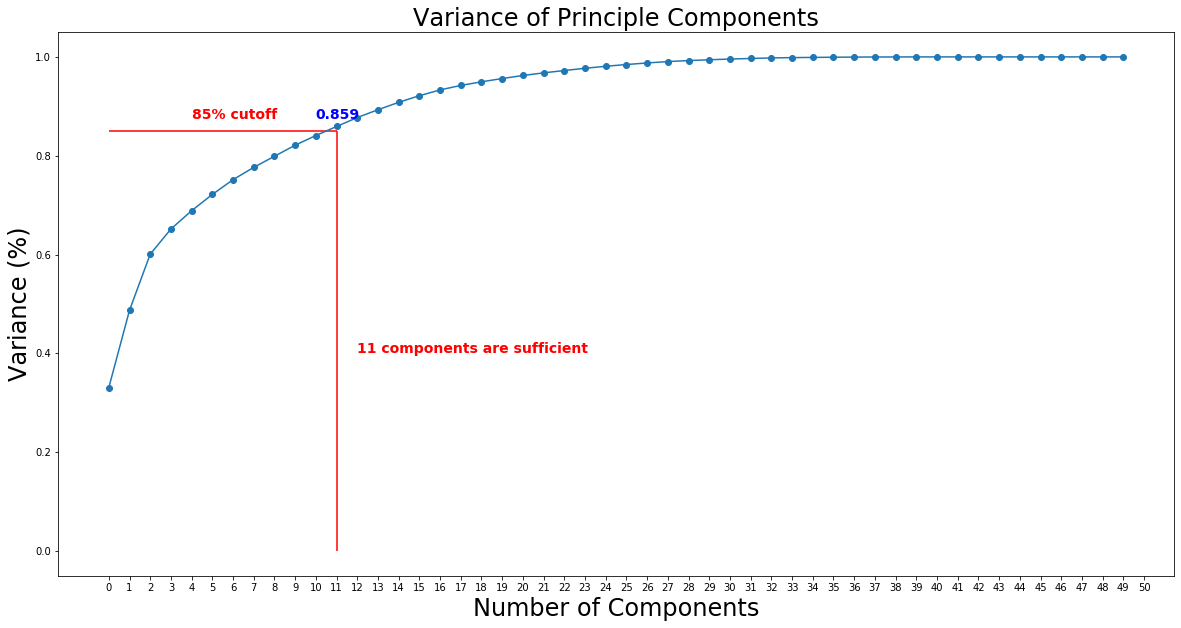

In [9]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_std)
pca_variance_components = np.cumsum(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
## Plot Parameters
plt.figure(figsize=(20,10))
plt.plot(pca_variance_components, '-o')
plt.xlabel('Number of Components', fontsize = 24)
plt.xticks(range(0,51))
plt.ylabel('Variance (%)', fontsize = 24) 
plt.title('Variance of Principle Components', fontsize = 24)

## Annotate plot 
plt.text(4, pca_variance_components[11] + 0.015,
         '85% cutoff', size = 14, color = 'red', weight = 'semibold')

plt.hlines(y = 0.85, color='red', linestyle = '-', xmin = 0.0, xmax = 11)

plt.text(10, pca_variance_components[11] + 0.015,
         str(round(pca_variance_components[11], 3)), size = 14, color = 'blue', weight = 'semibold')

plt.text(12, 0.4,
         '11 components are sufficient', size = 14, color = 'red', weight = 'semibold')

plt.vlines(x=11, color='red', linestyle = '-', ymin = 0.0, ymax = 0.85)

plt.show()

Let's see how the variance is distributed across our components. We identify that 3-4 components contain most of variance (~60%), so we'll examine those first four components in our visualizations.

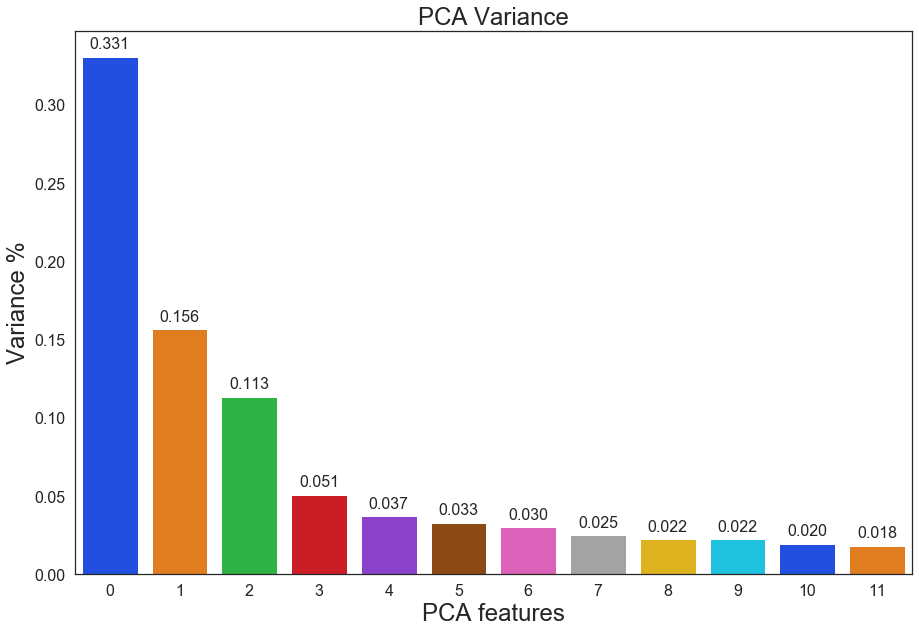

In [10]:
## Principle Components Analysis
# Set PCA parameters
pca = PCA(n_components = 12, random_state = 10)

# Fit and transform
principalComponents = pca.fit(X_train_std)
features = range(pca.n_components_)
principalComponents_variance = principalComponents.explained_variance_ratio_

# Plot the expected variance
plt.figure(figsize = (15,10))
sns.set(style = "white", rc = {"lines.linewidth": 3})
ax = sns.barplot(x = np.array(features), y = principalComponents.explained_variance_ratio_, palette = "bright")
plt.xlabel('PCA features', fontsize = 24)
plt.ylabel('Variance %', fontsize = 24)
plt.title('PCA Variance', fontsize = 24)
plt.xticks(features, fontsize = 16)
plt.yticks(fontsize = 16)

# Function to add labels to bar chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize = '16',            # Font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above
add_value_labels(ax)

plt.show()

Before, we begin with clustering we want to transform the training data using PCA.

In [11]:
# Set PCA number of components
pca = PCA(n_components = 12, random_state = 10)

In [12]:
def pca_Fit_Transform(df):
    """Function to fit and transform the dataframe and rename the PCA components"""
    PCA_DF = pca.fit_transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [13]:
def pca_Transform(df):
    """Function to transform the dataframe and rename the PCA components"""
    PCA_DF = pca.transform(df)
    PCA_DF = pd.DataFrame(PCA_DF)
    
    # Rename PCA column names
    x = (np.array(PCA_DF.columns)+1)
    columns = []
    for i in x:
        columns.append('PCA' + ' ' + str(i))
    PCA_DF.columns = columns
    
    return PCA_DF

In [41]:
PCA_components_train = pca_Fit_Transform(X_train_std)
PCA_components_dev = pca_Transform(X_dev_std)
PCA_components_test = pca_Transform(X_test_std)

#### DBSCAN


DBSCAN clustering is an algorithm, which groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points [2]. It also marks as outliers the points that are in low-density regions.

##### Algorithm
1. Arbitrarily select a point P.
2. Retrieve all points directly density-reachable from P with respect to ε.
3. If P is a core point, a cluster is formed. Find recursively all its density connected points and assign them to the same cluster as P.
4. If P is not a core point, DBSCAN iterates through the remaining unvisited points in the dataset.


##### Parameters

In DBSCAN, we'll be examining two parameters:
* minPoints: the minimum number of points to form a dense region.
* eps: specifies how close points should be to each other to be considered a part of a cluster. 

For minPoints, we will use a guideline in the original DBSCAN paper [2].

minPoints = 2*dimensions (number of features)

minPoints = 2 * 12 = 24

For eps, we will use a K-nearest-neighbors distance plot to identify the knee in the plot and select that distance [2].

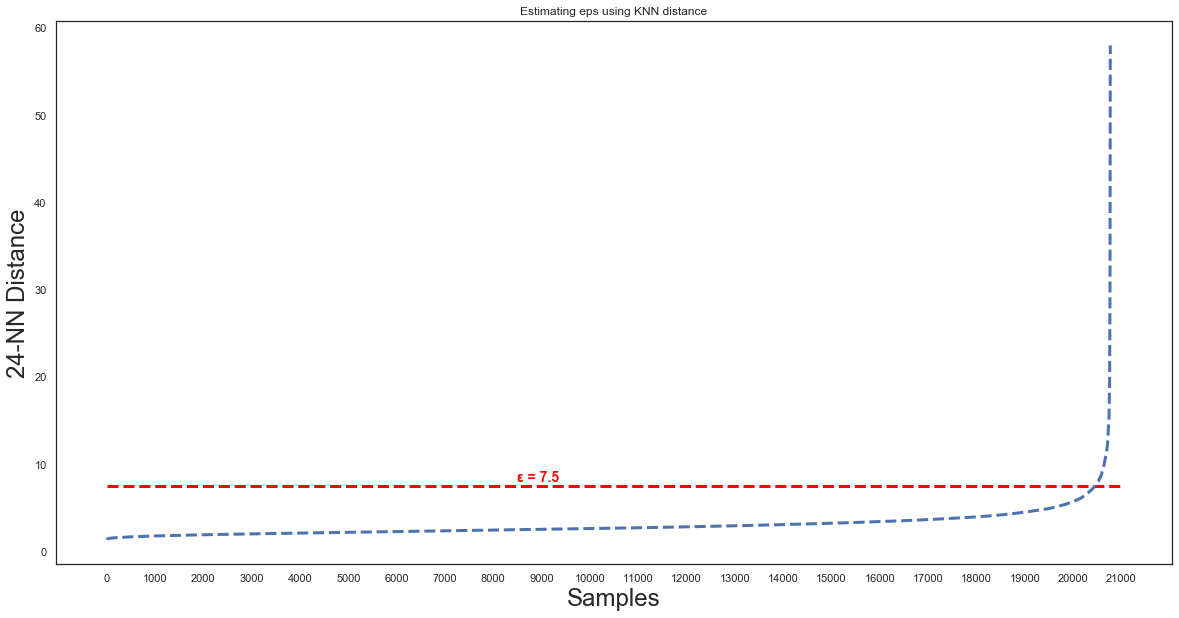

In [42]:
ns = 24
nbrs = NearestNeighbors(n_neighbors = ns).fit(PCA_components_train)
distances, indices = nbrs.kneighbors(PCA_components_train)
distanceDec = sorted(distances[:,ns-1], reverse = False)
plt.figure(figsize = (20, 10))
plt.plot(list(range(1, 20772)),
         distanceDec, '--')
plt.xticks(range(0, 22000, 1000))
plt.xlabel('Samples', fontsize = 24)
plt.ylabel('24-NN Distance', fontsize = 24)
plt.title('Estimating eps using KNN distance')

# Annotate Graph
plt.hlines(y = 7.5, color = 'red', linestyle = '--', xmin = 0, xmax = 21000)

plt.text(8500, 8, 'ε = 7.5', size = 14, color = 'red', weight = 'semibold')

plt.show()

Begin with configuring all parameters for DBSCAN.

In [43]:
# DBSCAN on Training Data
dbscan = DBSCAN( eps = 7.5, min_samples = 24).fit(PCA_components_train)
labels = dbscan.labels_

Silhouette analysis studies how similar and dissimilar neighboring cluster centroids are. We select the point which is closest to +1. In our case, the parameters have a silhouette score of 0.7672.

In [44]:
ss = metrics.silhouette_score(PCA_components_train, dbscan.labels_)
print('The Silhouette Score for the training set is ' + str(ss) + ".")

The Silhouette Score for the training set is 0.7195870042857551.


Next, load in our function to plot our 3D scatter plots.

In [45]:
def scatter3d_cluster(df, x, y, z, code, title):
    scatter = px.scatter_3d(df, x=x, y=y, z=z, color = code,  
                            color_discrete_sequence=px.colors.qualitative.Light24)
    
    scatter.update_layout(title = title, title_font = dict(size = 30),
                          scene = dict(
                              xaxis = dict(
                                  backgroundcolor="rgb(200, 200, 230)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16)),
                              yaxis = dict(
                                  backgroundcolor="rgb(230, 200,230)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16)),
                              zaxis = dict(
                                  backgroundcolor="rgb(230, 230,200)",
                                  gridcolor="white",
                                  showbackground=True,
                                  zerolinecolor="white",
                                  nticks=10, ticks='outside',
                                  tick0=0, tickwidth = 4,
                                  title_font = dict(size = 16),
                              ),
                          ),
                          width = 700
                         )
    return scatter.show()

Lastly, plot the data and let's label the data with our assumptions on how hackers are perceived.

Hackers tend to have high Kill-Death Ratios, Headshot-Kill Ratios, Top 10 Ratios, and Win Ratios.

In [47]:
## 3D Plot of Training Data
# Create and modify dataframe for the cluster column
PCA_components_train['Cluster'] = pd.Series(labels, index = PCA_components_train.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Humans", -1: 'Hackers'}
PCA_components_train['Cluster_Labels'] = PCA_components_train['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_train , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

In [48]:
PCA_components_train['Cluster'].value_counts()

 0    20639
-1      132
Name: Cluster, dtype: int64

From the plots, we observed roughly 20706 humans and 65 hackers. Compared to only DBSCAN, PCA + DBSCAN has resulted in less outliers (hackers) detected.

In [49]:
PCA_components_train.groupby('Cluster_Labels').count()

PCA 1  PCA 2  PCA 3  PCA 4  PCA 5  PCA 6  PCA 7  PCA 8  PCA 9  \
Cluster_Labels                                                                  
Hackers           132    132    132    132    132    132    132    132    132   
Humans          20639  20639  20639  20639  20639  20639  20639  20639  20639   

                PCA 10  PCA 11  PCA 12  Cluster  
Cluster_Labels                                   
Hackers            132     132     132      132  
Humans           20639   20639   20639    20639

##### Predicting on the dev set

Begin with predicting on the dev set.

In [50]:
def dbscan_predict(model, X):
    "Predict function created for DBSCAN"
    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X.iloc[i, :].values  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [51]:
predict_labels = dbscan_predict(dbscan, PCA_components_dev)

Next, create the 3D scatter plots.

In [52]:
## 3D Plot of deving Data
# Create and modify dataframe for the cluster column
PCA_components_dev['Cluster'] = pd.Series(predict_labels, index = PCA_components_dev.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Humans", -1: 'Hackers'}
PCA_components_dev['Cluster_Labels'] = PCA_components_dev['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_dev , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 7079 humans and 42 hackers.

In [54]:
PCA_components_dev.groupby('Cluster_Labels').count()

PCA 1  PCA 2  PCA 3  PCA 4  PCA 5  PCA 6  PCA 7  PCA 8  PCA 9  \
Cluster_Labels                                                                  
Hackers            42     42     42     42     42     42     42     42     42   
Humans           7079   7079   7079   7079   7079   7079   7079   7079   7079   

                PCA 10  PCA 11  PCA 12  Cluster  
Cluster_Labels                                   
Hackers             42      42      42       42  
Humans            7079    7079    7079     7079

##### Predicting on the test set

Begin with predicting on the test set.

In [55]:
# DBSCAN on test data
predict_labels = dbscan_predict(dbscan, PCA_components_test)

Next, create the 3D scatter plots.

In [56]:
## 3D Plot of testing Data
# Create and modify dataframe for the cluster column
PCA_components_test['Cluster'] = pd.Series(predict_labels, index = PCA_components_test.index)

#Rename Cluster label names from k-means
cluster_label_names = {0: "Humans", -1: 'Hackers'}
PCA_components_test['Cluster_Labels'] = PCA_components_test['Cluster'].map(cluster_label_names)  

# Plots of PCA 1, PCA 2, PCA 3
scatter3d_cluster(df = PCA_components_test , x = 'PCA 1',
                  y = 'PCA 2', z = 'PCA 3', code = 'Cluster_Labels', title = 'PCA')

From the plots, we observed roughly 1775 humans and 6 hackers.

In [59]:
PCA_components_test.groupby('Cluster_Labels').count()

PCA 1  PCA 2  PCA 3  PCA 4  PCA 5  PCA 6  PCA 7  PCA 8  PCA 9  \
Cluster_Labels                                                                  
Hackers             6      6      6      6      6      6      6      6      6   
Humans           1775   1775   1775   1775   1775   1775   1775   1775   1775   

                PCA 10  PCA 11  PCA 12  Cluster  
Cluster_Labels                                   
Hackers              6       6       6        6  
Humans            1775    1775    1775     1775

### Remarks
* Without external labels, we cannot verify the accuracy of these clusters. But we can make an educated guess on what these clusters are by using domain experience and advice from experts playing the game.
* Treating this problem as an outlier detection (anomaly detection) problem has yielded promising results.
    * With the assumption that the number of hackers in our population is low, we can treat them as outliers.
* However, most of the outliers in our models can be misclassifying actual humans, so further tuning needs to be done to reduce that misclassification rate.
* Look into alternative anomaly detection algorithms.

### References
[1] https://www.cs.cmu.edu/~elaw/papers/pca.pdf

[2] Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. ACM Transactions on Database Systems (TODS), 42(3), 19.